# Data Preparation

## Loading the MNIST dataset

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1, as_frame=False)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [12]:
import numpy as np

X = mnist.data
y = mnist.target.astype(np.uint8)

In [13]:
X.shape

(70000, 784)

In [14]:
y.shape

(70000,)

In [15]:
# setting aside 10_000 examples for testing
X_train, X_test, y_train, y_test = X[:60_000], X[60_000:], y[:60_000], y[60_000:]

In [16]:
import matplotlib.pyplot as plt

def plot_digit(digit_aray):
    # a function for plotting the digit given it's array
    plt.imshow(digit_aray.reshape(28, 28), cmap="binary")
    plt.axis("off")
    plt.show()

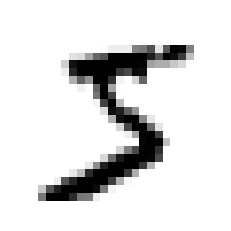

In [17]:
plot_digit(digit_aray=X_train[0])

In [20]:
import numpy as np

def switch_colors(digit_array):
    # function for changing all white colors to black and black colors to white
    return (np.full(len(digit_array), 255, dtype=int) - digit_array)


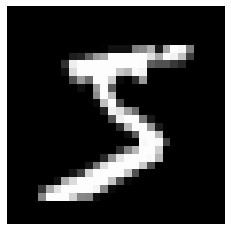

In [21]:
plot_digit(switch_colors(X_train[0]))